In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')

In [2]:
import metavars
metavars.lake_name = 'synth'        # set to 'synth' or one of the lakes in the inventory
lake_name = metavars.lake_name
from make_synth_data import make_data


In [3]:
H = 2000
lamda = 0.5
gamma = 1
eta = 0.5*(917*9.81*H)*3.154e7/(2*lamda)
beta = 2*eta*gamma/H

t_cycle = 5
dir_name = '../results/N_gamma_'+'{:.1f}'.format(gamma)
!rm -r {dir_name};
!mkdir {dir_name}
make_data(t_cycle,beta,eta,H)

Print the auxiliar parameters (ice thickness, basal drag, viscosity, velocities):

In [4]:
# print the auxiliary model parameters
from print_params import print_params
print_params()

auxiliary model parameters:
H = 2.0 km
beta = 2.84e+11 Pa s m^-1
eta = 2.84e+14 Pa s
u = 0.0 m yr^-1
v = 0.0 m yr^-1
relaxation time = 1.0 yr


Calculate the effective pressure!

In [5]:
from kernel_fcns import fftd,ifftd,C_h,C_w
from params import data_dir,lamda0,delta,N_sc,x0,y0,t0
from post_process import calc_s
# load elevation data (h_obs)
h = np.load(data_dir+'/h_true.npy')
w = np.load(data_dir+'/w_true.npy')
s = calc_s(w,initial=0)
h_ft = fftd(h)
w_ft = fftd(w)
s_ft = fftd(s)
N_ft = (1/lamda0)*C_w()*w_ft - C_h()*h_ft - delta*s_ft
N = ifftd(N_ft).real


In [6]:
np.save(dir_name+'/N.npy',N)
np.save(dir_name+'/w.npy',w)
np.save(dir_name+'/h.npy',h)
np.save(dir_name+'/x.npy',x0)
np.save(dir_name+'/y.npy',y0)
np.save(dir_name+'/t.npy',t0)

In [7]:
xp,yp = np.meshgrid(x0,y0)
rad = 4
bdry = 1+0*xp
bdry[np.sqrt((xp)**2+(yp)**2)>rad] = 0

In [8]:
def get_means(N,w,h,bdry):
    N_mean = np.zeros(N.shape[0])
    w_mean = np.zeros(w.shape[0])
    h_mean = np.zeros(h.shape[0])

    for i in range(N.shape[0]):
        N_i = N[i,:,:]
        w_i = w[i,:,:]
        h_i = h[i,:,:]

        N_mean[i] = N_i[bdry>1e-2].mean()
        w_mean[i] = w_i[bdry>1e-2].mean()
        h_mean[i] = h_i[bdry>1e-2].mean()
    return N_mean, w_mean, h_mean   

N_mean, w_mean, h_mean   = get_means(N,w,h,bdry)


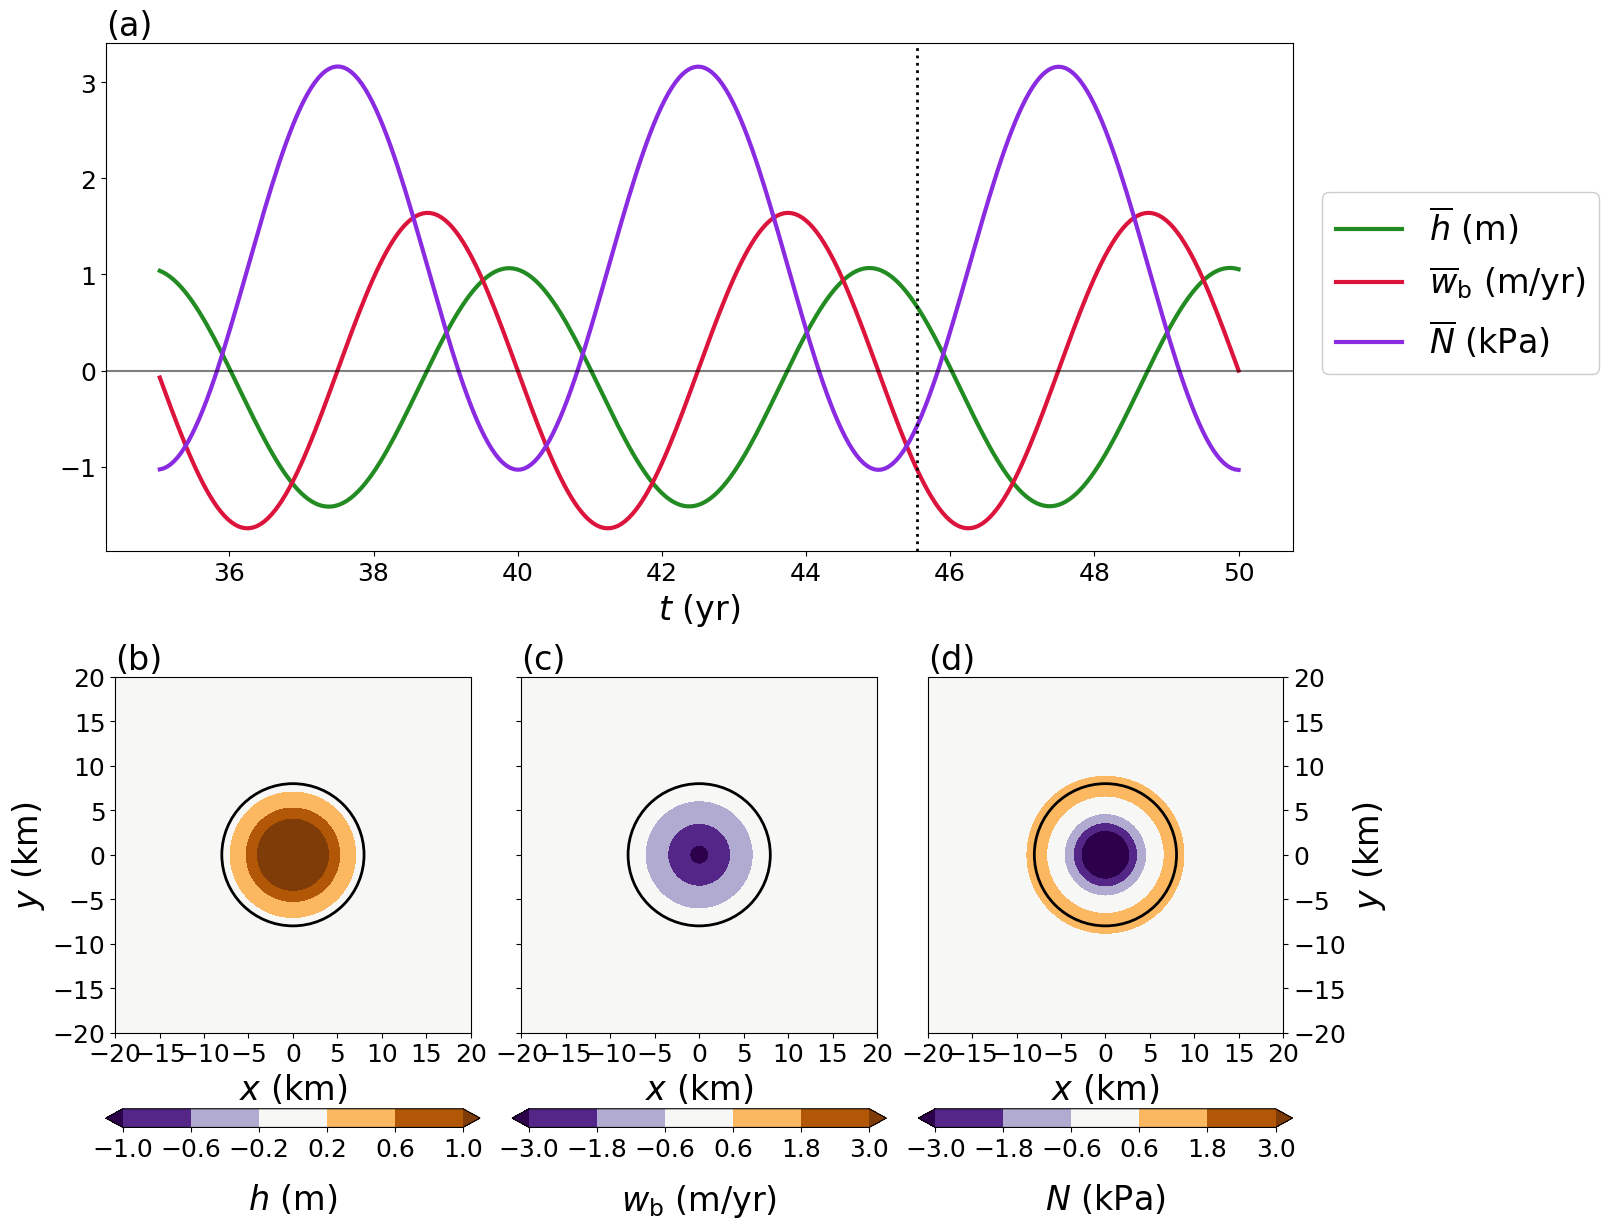

In [20]:
xp,yp = np.meshgrid(x0*H/1e3,y0*H/1e3)

l = 910
j0 = int(0.7*t0.size)
plt.figure(figsize=(16,12.5))

plt.subplot(211)
plt.title('(a)',loc='left',fontsize=24)
plt.plot(t0[j0:None],h_mean[j0:None],color='forestgreen',linewidth=3,label=r'$\overline{h}$ (m)')
plt.plot(t0[j0:None],w_mean[j0:None],color='crimson',linewidth=3,label=r'$\overline{w}_\mathrm{b}$ (m/yr)')
plt.plot(t0[j0:None],N_mean[j0:None]*N_sc/1e3,color='blueviolet',linewidth=3,label=r'$\overline{N}$ (kPa)')
plt.axvline(x=t0[l],color='k',linestyle=':',linewidth=2)
plt.axhline(y=0,color='k',linestyle='-',alpha=0.5)
plt.xlabel(r'$t$ (yr)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=24,loc=(1.025,0.35),framealpha=1)

plt.subplot(234)
plt.title('(b)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,h[l,:,:],cmap='PuOr_r',levels=np.linspace(-1,1,6),extend='both')
circle = plt.Circle((0, 0), rad*H/1e3, color='k',fill=False,linewidth=2)
plt.gca().add_patch(circle)
cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$h$ (m)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')


plt.subplot(235)
plt.title('(c)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,w[l,:,:],cmap='PuOr_r',levels=np.linspace(-3,3,6),extend='both')
circle = plt.Circle((0, 0), rad*H/1e3, color='k',fill=False,linewidth=2)
plt.gca().add_patch(circle)
cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$w_\mathrm{b}$ (m/yr)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.gca().yaxis.set_ticklabels([])
plt.gca().set_aspect('equal', 'box')

plt.subplot(236)
plt.title('(d)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,N[l,:,:]*N_sc/1e3,cmap='PuOr_r',levels=np.linspace(-3,3,6),extend='both')
circle = plt.Circle((0, 0), rad*H/1e3, color='k',fill=False,linewidth=2)
plt.gca().add_patch(circle)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')

cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$N$ (kPa)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('fig3')
plt.show()
plt.close()